In [5]:
import pandas as pd
import numpy as np
import os,sys,time
from pathlib import Path
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import glob,shutil
from datetime import datetime,timedelta
import plotly.express as px
from matplotlib import dates as mdates
import scipy.stats as ss 
import re
import math
from statsmodels.stats.power import TTestIndPower
import statsmodels.stats.api as sms
import scipy.stats as stats
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
from sklearn.utils import resample
from sklearn.metrics import accuracy_score
from statsmodels.stats.proportion import proportion_effectsize

In [95]:
input_path = r'D:\work\project\cac\campaign\sitime'

In [118]:
# date period 2022-02-14 to 2022-03-13 (4 weeks)
#df = pd.read_excel(os.path.join(input_path, 'SiTime-S3-Tie_2022_03_15.xlsx'))

#date period 28th Feb to 13th Mar
#file_name = 'Report 16-Mar-2022(updated_till_15th).xlsx'
# file_name = 'Report_4th_MAY_2022.xlsx'
file_name = 'Report_6.9.2022.xlsx'
df = pd.read_excel(os.path.join(input_path, file_name), sheet_name = 0)

In [119]:
df['Geo'] = df['adName'].str.split(r"(Ad)").str[-1]
df['Geo'] = df['Geo'].str.replace('-|_','')
df['date'] = df['ImpressionTime'].dt.date
df['date'] = pd.to_datetime(df['date'], format="%Y-%m-%d")

C:\Users\SHUBHA~1.GUP\AppData\Local\Temp/ipykernel_24452/977720485.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Geo'] = df['Geo'].str.replace('-|_','')


In [120]:
df.fillna(0, inplace = True)

In [121]:
df['zoneid'] = df['zoneid'].astype(int)
df['campaignid'] = df['campaignid'].astype(int)
df['adid'] = df['adid'].astype(int)
df['Clicks'] = df['Clicks'].astype(int)
df['PVs'] = df['PVs'].astype(int)

In [100]:
def get_product(df):
    if re.search( "khz-oscillators", df['pageurl']):
        return "khz-oscillators"
    elif re.search( "lvcmos-oscillators", df['pageurl']):
        return "lvcmos-oscillators"
    else:
        return "null"

In [122]:
df['pro_category'] = df.apply(get_product, axis = 1)

In [123]:
df_all = df.copy()

In [103]:
#df = df[df['date'] >= '2022-03-08']

In [104]:
def vid_split(df):
    t = df.groupby(['Grp'])['atag'].nunique().reset_index()
    t['per'] = (t['atag']/t['atag'].sum())*100
    return t   

In [105]:
def vid_split_new(df):
    t = df.groupby(['Grp'])['adreqid'].agg('count').reset_index()
    t['per'] = (t['adreqid']/t['adreqid'].sum())*100
    return t   

In [106]:
def cal_min(df):
    if (df['ACTIVE_3M_YN'] == 'Y'):
        return 180
    elif (df['ACTIVE_2M_YN'] == 'Y'):
        return 120
    elif (df['ACTIVE_1M_YN'] == 'Y'):
        return 60
    elif (df['ACTIVE_30S_YN'] == 'Y'):
        return 30
    else:
        return 0

In [107]:
def cal_avg_time(df, group):
    t = df[df['Grp'] == group].groupby(['PVs', 'ACTIVE_30S_YN',  'ACTIVE_1M_YN', 'ACTIVE_2M_YN', 'ACTIVE_3M_YN'])['adreqid'].agg('count').reset_index()
    t['time_in_sec']  = t.apply(cal_min, axis = 1)
    t = t.groupby(['PVs', 'time_in_sec'])['adreqid'].agg('sum').reset_index()
    t['total_time_in_sec'] = t['time_in_sec']*t['adreqid']
    df1 = t.groupby(['PVs'])['total_time_in_sec'].agg('sum').reset_index()
    df2 = t.groupby(['PVs'])['adreqid'].agg('sum').reset_index()
    t = pd.merge(df1, df2, on = 'PVs', how = 'inner')
    t['avg_time'] = round(t['total_time_in_sec']/t['adreqid'],2)
    return t

In [108]:
def cal_avg_time_new(df, group, pv_level = False):
    group1 = ['date','PVs', 'ACTIVE_30S_YN',  'ACTIVE_1M_YN', 'ACTIVE_2M_YN', 'ACTIVE_3M_YN']
    group2 = ['date','PVs', 'time_in_sec']
    group3 = ['date', 'PVs']
    if pv_level is False:
        group1.remove('PVs')
        group2.remove('PVs')
        group3.remove('PVs')
    t = df[df['Grp'] == group].groupby(group1)['adreqid'].agg('count').reset_index()
    t['time_in_sec'] = t.apply(cal_min, axis = 1)
    t = t.groupby(group2)['adreqid'].agg('sum').reset_index()
    t['total_time_in_sec'] = t['time_in_sec']*t['adreqid']
    t = t.groupby(group3)['total_time_in_sec', 'adreqid'].agg('sum').reset_index()
    t['avg_time'] = round(t['total_time_in_sec']/t['adreqid'],2)
    return t

### Analysis 1 - success rate % test vs control - part 1

In [109]:
def success_rate_split(df, active):
    df = df.copy()
    temp = []
    groups = ['Control', 'Test']
    for group in groups:
        t = df[df['Grp'] == group].groupby(['date','PVs', active])['channelsessionid'].nunique().reset_index()
        active_df = t[(t[active] == 'Y') | (t['PVs'] >= 2)].groupby(['date'])['channelsessionid'].agg('sum').reset_index()
        active_df = active_df.groupby(['date'])['channelsessionid'].agg('sum').reset_index()
        active_channelsessionid = f'{group}_active_channelsessionid'
        active_df.rename(columns = {'channelsessionid':active_channelsessionid}, inplace = True)
        t = t.groupby(['date'])['channelsessionid'].agg('sum').reset_index()
        total_channelsessionid = f'{group}_total_channelsessionid'
        t.rename(columns = {'channelsessionid':total_channelsessionid}, inplace = True)
        t = pd.merge(t, active_df, on = 'date', how = 'inner')
        success_rate = f'{group}_success_rate'
        t[success_rate] = round((t[active_channelsessionid]/t[total_channelsessionid])*100,2)
        temp.append(t)
    t = pd.concat(temp, axis =1, join = 'inner')
    t = t.loc[:,~t.columns.duplicated()]
    return t

In [27]:
temp = success_rate_split(df, 'ACTIVE_2M_YN')
#temp.to_csv('test_vs_control_success_rate.csv', index = False)

In [28]:
temp = temp[['date','Test_success_rate', 'Control_success_rate']]

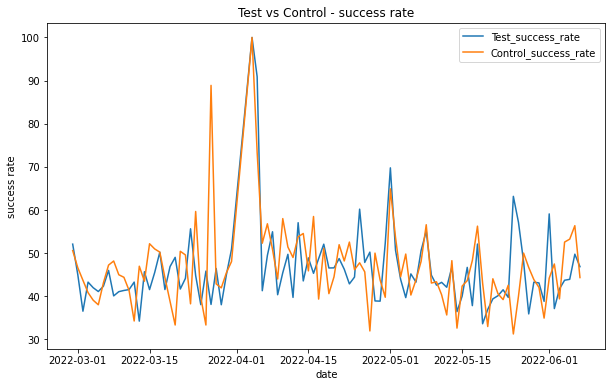

In [29]:
plt.figure(figsize = (10,6)) 
ax = sns.lineplot(x='date', y='value', hue='variable', data=pd.melt(temp, ['date']))
ax.set(xlabel='date', ylabel='success rate')
#plt.xticks(rotation=45)
plt.legend(title='')
plt.title("Test vs Control - success rate")
plt.savefig('test_vs_control_success_rate.png')
plt.show()

In [30]:
def get_dist_plot(df, xlabel, plot_name):
    plt.figure(figsize = (10,6)) 
    ax = sns.displot(data=pd.melt(df, ['date']), x='value', hue='variable', kind='kde', fill=True) #col='variable')
    ax.set(xlabel=xlabel)
    plt.savefig(plot_name)
    plt.show()

In [31]:
def t_test_new(df, col1, col2, test_type = 'not paired'):
    if test_type == 'paired':
        t_stat, p_val= ss.ttest_rel(df[col1], df[col2])
    else:
        t_stat, p_val= ss.ttest_ind(df[col1], df[col2])
    return round(t_stat,5), round(p_val,5)

In [32]:
def power_analysis(df):
    t = df.describe()
    mean_diff = (t.iloc[[1],0][0] - t.iloc[[1],1][0])
    pooled_st_dv = math.sqrt(((t.iloc[[2],0][0])**2 + (t.iloc[[2],1][0])**2)/2)
    effect = mean_diff/pooled_st_dv # how is the overlap b/w two distribution, can also be cal from corr coeff
    #effect = -0.1742
    alpha = 0.05
    power = 0.8
    # perform power analysis
    analysis = TTestIndPower()
    sam_size = analysis.solve_power(effect, power=power, nobs1=None, ratio=1.0, alpha=alpha)
    #print('Sample Size: %.3f' % result)
    return round(sam_size), round(effect,4)

In [33]:
def conduct_stat_test(df, dst_plot_xlabel, dst_plot_name, col1, col2 ):
    get_dist_plot(df, dst_plot_xlabel, dst_plot_name)
    t_stat_b, p_value_b = t_test_new(df, col1, col2)
    sam_size, effect = power_analysis(df)
    t = df.describe()
    df1_new = np.random.normal(t.iloc[[1],0][0], t.iloc[[2],0][0], sam_size)
    df2_new = np.random.normal(t.iloc[[1],1][0], t.iloc[[2],1][0], sam_size)
    t = pd.DataFrame({col1: df1_new.tolist(), col2: df2_new.tolist()})
    t_stat_a, p_value_a = t_test_new(t, col1, col2)
    print("t_stat_b: %s p_value_b: %s t_stat_a: %s p_value_a: %s  sam_size: %s  effect: %s"  %(t_stat_b, p_value_b, t_stat_a, p_value_a, sam_size, effect))
    return

<Figure size 720x432 with 0 Axes>

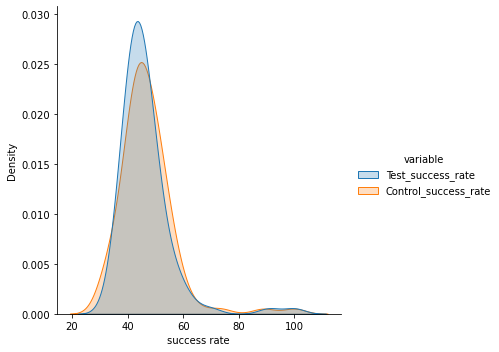

t_stat_b: -0.46015 p_value_b: 0.64593 t_stat_a: -2.28999 p_value_a: 0.02205  sam_size: 3597  effect: -0.0661


In [34]:
conduct_stat_test(temp, 'success rate', 'test_vs_control_success_rate_dst.png', 'Test_success_rate', 'Control_success_rate')

### Analysis 1 - part 2

In [35]:
def cal_success_col(row):
    if (row['ACTIVE_2M_YN'] == 'Y') | (row['PVs'] >= 2):
        success = 1
    else:
        success = 0
    return success

In [ ]:
# filtering for united states and siT8008 data


In [124]:
df.head(2)

,ImpressionTime,adreqid,zoneid,campaignid,adid,adName,city_geo,ipcity,country,ipcountry,...,Click_YN,PVs,url,ACTIVE_30S_YN,ACTIVE_1M_YN,ACTIVE_2M_YN,ACTIVE_3M_YN,Geo,date,pro_category
0,2022-02-28 03:58:19,a0057ff1-9029-48df-ad2d-6c365d14d9ea,4635,1026,6531,khz_oscillatorsAd-NonGeo,Rennes,Sainte-Maxime,France,France,...,N,1,https://www.sitime.com/solutions,0,0,Y,0,NonGeo,2022-02-28,khz-oscillators
1,2022-02-28 08:44:33,ebdfaed9-cd4a-46d4-9fc9-83fb1af0d5a0,4635,1026,6531,khz_oscillatorsAd-NonGeo,Grove City,Pickerington,United States,United States,...,N,1,https://www.sitime.com/solutions,0,0,Y,0,NonGeo,2022-02-28,khz-oscillators


In [127]:
#t = df[['date','PVs', 'ACTIVE_2M_YN','channelsessionid', 'adreqid', 'Grp']]
t = df[['date','PVs', 'ACTIVE_2M_YN','channelsessionid', 'adreqid', 'Grp', 'pro_category', 'country_final']]

In [128]:
t['success'] = t.apply(cal_success_col, axis = 1)

C:\Users\SHUBHA~1.GUP\AppData\Local\Temp/ipykernel_24452/1249666259.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t['success'] = t.apply(cal_success_col, axis = 1)


In [129]:
t = t[t['country_final'] == 'United States']

In [130]:
t.groupby(['pro_category', 'Grp'])['success'].agg('sum').reset_index()

,pro_category,Grp,success
0,khz-oscillators,Control,1332
1,khz-oscillators,Test,1502
2,lvcmos-oscillators,Control,1302
3,lvcmos-oscillators,Test,1451


In [377]:
# remove session with multiple ads 
# t = df[df['PVs'] >= 2][['date','PVs', 'ACTIVE_2M_YN','channelsessionid', 'adreqid', 'Grp']].groupby(['channelsessionid'])['adreqid'].agg('count').reset_index()
# df[df['channelsessionid'].isin(t[t['adreqid']<2]['channelsessionid'])]

In [378]:
#t = df[df['PVs'] >= 2][['date','PVs', 'ACTIVE_2M_YN','channelsessionid', 'adreqid', 'Grp']].groupby(['Grp', 'ACTIVE_2M_YN'])['channelsessionid'].agg('count').reset_index()

In [379]:
## z-test for proportions
# https://stats.stackexchange.com/questions/113602/test-if-two-binomial-distributions-are-statistically-different-from-each-other/113607#113607

In [39]:
def get_proportion_table(df):
    aggs = {'count' : 'trials', 'sum' : 'successes', 'mean' : 'rate'}
    con_tab = []
    for agg, col in aggs.items():
        temp = df.groupby(['Grp'])['success'].agg(agg).reset_index()
        temp.rename(columns = {'success': aggs[agg]}, inplace = True)
        con_tab.append(temp)
        temp = pd.concat(con_tab, axis=1)
        temp = temp.loc[:,~temp.columns.duplicated()]
    return temp

In [40]:
def z_test_binom(n1, p1, n2, p2):
    p_hat = (n1*p1 + n2*p2) / (n1+n2)
    A = math.sqrt(p_hat * (1-p_hat))
    B = math.sqrt((n1+n2)/(n1*n2))
    z_actual = (p1-p2)/ (A * B)
    return z_actual

In [134]:
#t = t[t['pro_category'] == 'khz-oscillators']
t = t[t['pro_category'] == 'lvcmos-oscillators']

In [136]:
temp = get_proportion_table(t)

In [137]:
temp

,Grp,trials,successes,rate
0,Control,2426,1302,0.536686
1,Test,2659,1451,0.545694


In [138]:
n1 = temp[temp['Grp'] == 'Control']['trials'][0]
p1 = temp[temp['Grp'] == 'Control']['rate'][0]
n2 = temp[temp['Grp'] == 'Test']['trials'][1]
p2 = temp[temp['Grp'] == 'Test']['rate'][1]

In [144]:
# at alpha 0.05,  z = 1.96
z = z_test_binom(n1, p1, n2, p2)
# abs(z) >= 1.96
p_val = ss.norm.sf(abs(z))*2
p_val

0.519648900777899

In [159]:
z

-0.6438867093921788

In [46]:
# effect size in binomial distribution is describe in terms of relative risk, using Cohen's h phi difference b/w the proportion
# https://stats.stackexchange.com/questions/176847/effect-size-of-a-binomial-test-and-its-relation-to-other-measures-of-effect-size#:~:text=It%20is%20calculated%20as%201,e%20is%20the%20expected%20probability.
# https://en.wikipedia.org/wiki/Cohen's_h

phi = 2 * arcsin(sqrt * pi)
h2 = phi1 - phi2

pi = observed proportion
pe = expected proportion

0 < h2 < 0.20: "small effect size"
0.20 < h2 < 0.50: "medium effect size"
0.50 < h2 < 0.80: "large effect size"
# this is for paired data


SyntaxError: invalid syntax (Temp/ipykernel_24452/2351002928.py, line 8)

In [47]:
pe = 0.5

phi1 = 2 * math.asin(p1**0.5)
phi2 = 2 * math.asin(p2**0.5)
phic = 2 * math.asin(pe**0.5)
print(phi1, phi2, phic)

h2 = phi1 - phic
print(h2)

1.6819371070211848 1.6730687634177597 1.5707963267948968
0.11114078022628804


In [148]:
proportion_effectsize(p2, pe)

0.09151542767583787

In [49]:
h = h2 * 2**0.5
print(h)

0.15717679872874407


In [50]:
pe = 0.5
def cohenH2(prop1, prop2):
    phi1 = 2 * math.asin(prop1**0.5)
    phi2 = 2 * math.asin(prop2**0.5)
    
    h2 = phi1 - phi2    
    h2Nondir = abs(h2)
    print('Cohen\'s directional h2: = ' + str(h2))
    print('Cohen\'s nondirectional h2: = ' + str(h2Nondir))
    
    #convert to h to use it for one-sample, h2 is for paired sample
    h = h2Nondir * 2 ** 0.5

    # for the interpretation
    result = 'Using Cohen\'s qualification this could be considered: '
    if h < .20:
        qual = 'Negligible'
    elif h < .50:
        qual = 'Small'
    elif h < .80:
        qual = 'Medium'
    else:
        qual = 'Large'
    print(result + qual)
    
#     # return Cohen's g and qualification
#     return h2Nondir, qual

In [143]:
cohenH2(p2, pe)

Cohen's directional h2: = 0.09151542767583787
Cohen's nondirectional h2: = 0.09151542767583787
Using Cohen's qualification this could be considered: Negligible


### Analysis 2 - daily avg time and avg PVs trend within groups

In [390]:
### t test on avg PVs and avg time (2mins)
#test vs control
#test Geo Ad vs control
#test Non Geo Ad vs control
#test Geo Ad vs test Non Geo Ad

#Geo Ad - City (Yes,No) - served personalised ad or non personalised ad
#Geo Non Ad - City (Yes, No) - only non personalised ad

In [52]:
def cal_time(df):
    if (df['ACTIVE_2M_YN'] == 'Y'):
        return 120
    else:
        return 0

In [53]:
def group_df(df, group, active):
    group1 = ['date','Geo','city_found', 'PVs', active]
    group2 = ['date','Geo','city_found', 'PVs']
    group3 = ['date', 'Geo', 'city_found']
    if group == 'Control':
        group1 = ['date','PVs', active]
        group2 = ['date','PVs']
        group3 = ['date']
    t = df[df['Grp'] == group].groupby(group1)['channelsessionid'].nunique().reset_index()
    t['time_in_sec'] = t.apply(cal_time, axis = 1)
    t['total_time_in_sec'] = t['time_in_sec']*t['channelsessionid']
    t = t.groupby(group2)['total_time_in_sec', 'channelsessionid'].agg('sum').reset_index()
    t['total_PVs'] = t['PVs']*t['channelsessionid']
    t = t.groupby(group3)['total_time_in_sec','total_PVs', 'channelsessionid'].agg('sum').reset_index()
    t['avg_time'] = round(t['total_time_in_sec']/t['channelsessionid'],2)
    t['avg_PVs'] = round(t['total_PVs']/t['channelsessionid'],2)
    t['Grp'] = group
    t.rename(columns = {'total_time_in_sec': f'{group}_total_time_in_sec', 'total_PVs': f'{group}_total_PVs', 'channelsessionid': f'{group}_channelsessionid', 'avg_time': f'{group}_avg_time', 'avg_PVs':f'{group}_avg_PVs'}, inplace = True)
    return t

In [54]:
test_df = group_df(df, 'Test', 'ACTIVE_2M_YN')
control_df = group_df(df, 'Control', 'ACTIVE_2M_YN')

C:\Users\SHUBHA~1.GUP\AppData\Local\Temp/ipykernel_24452/4210864246.py:12: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  t = t.groupby(group2)['total_time_in_sec', 'channelsessionid'].agg('sum').reset_index()
C:\Users\SHUBHA~1.GUP\AppData\Local\Temp/ipykernel_24452/4210864246.py:14: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  t = t.groupby(group3)['total_time_in_sec','total_PVs', 'channelsessionid'].agg('sum').reset_index()


In [55]:
test_df

,date,Geo,city_found,Test_total_time_in_sec,Test_total_PVs,Test_channelsessionid,Test_avg_time,Test_avg_PVs,Grp
0,2022-02-28,Geo,No,2640,136,60,44.00,2.27,Test
1,2022-02-28,Geo,Yes,960,41,16,60.00,2.56,Test
2,2022-02-28,NonGeo,No,1800,127,59,30.51,2.15,Test
3,2022-02-28,NonGeo,Yes,1440,48,21,68.57,2.29,Test
4,2022-03-01,Geo,No,3960,190,104,38.08,1.83,Test
...,...,...,...,...,...,...,...,...,...
385,2022-06-07,Geo,0,720,30,18,40.00,1.67,Test
386,2022-06-07,Geo,No,8400,366,226,37.17,1.62,Test
387,2022-06-07,Geo,Yes,720,33,21,34.29,1.57,Test
388,2022-06-07,NonGeo,No,11640,415,247,47.13,1.68,Test


In [56]:
control_df

,date,Control_total_time_in_sec,Control_total_PVs,Control_channelsessionid,Control_avg_time,Control_avg_PVs,Grp
0,2022-02-28,2160,158,85,25.41,1.86,Control
1,2022-03-01,7200,309,206,34.95,1.50,Control
2,2022-03-02,5040,169,135,37.33,1.25,Control
3,2022-03-03,5160,272,169,30.53,1.61,Control
4,2022-03-04,5280,249,174,30.34,1.43,Control
...,...,...,...,...,...,...,...
94,2022-06-03,5880,290,198,29.70,1.46,Control
95,2022-06-04,3000,148,78,38.46,1.90,Control
96,2022-06-05,5520,214,139,39.71,1.54,Control
97,2022-06-06,14520,610,346,41.97,1.76,Control


### test vs control

In [836]:
## deprecated
# def group_df_avg_time_and_pv(df):
#     group = df['Grp'][0]
#     t = df.groupby(['date'])['total_time_in_sec','total_PVs', 'channelsessionid'].agg('sum').reset_index()
#     t['avg_time'] = round(t['total_time_in_sec']/t['channelsessionid'],2)
#     t['avg_PVs'] = round(t['total_PVs']/t['channelsessionid'],2)
#     col = t.columns
#     col = col.to_list()
#     col = col[1:]
#     temp ={}
#     for each in col:
#         temp[each] = f'{group}_{each}'
#     t.rename(columns = temp, inplace = True)
#     return t   

In [57]:
t = test_df.groupby(['date'])['Test_total_time_in_sec','Test_total_PVs', 'Test_channelsessionid'].agg('sum').reset_index()
t['Test_avg_time'] = round(t['Test_total_time_in_sec']/t['Test_channelsessionid'],2)
t['Test_avg_PVs'] = round(t['Test_total_PVs']/t['Test_channelsessionid'],2)

C:\Users\SHUBHA~1.GUP\AppData\Local\Temp/ipykernel_24452/1240700366.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  t = test_df.groupby(['date'])['Test_total_time_in_sec','Test_total_PVs', 'Test_channelsessionid'].agg('sum').reset_index()


In [58]:
#control_df = control_df.drop(['Grp'], axis = 1)
temp = pd.merge(t[['date', 'Test_avg_time']],control_df[['date','Control_avg_time']], on = 'date', how = 'inner')
#temp.to_csv('test_vs_control_avg_time.csv', index = False)

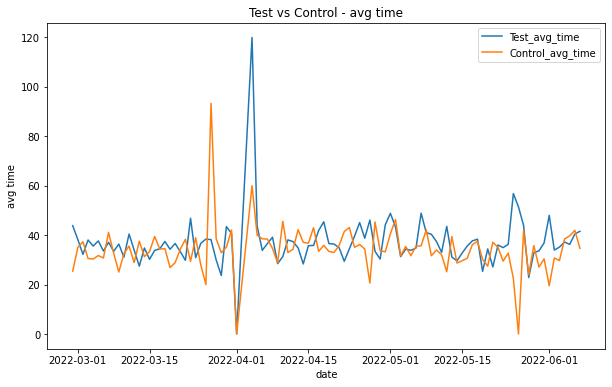

In [59]:
plt.figure(figsize = (10,6)) 
ax = sns.lineplot(x='date', y='value', hue='variable', data=pd.melt(temp[['date','Test_avg_time','Control_avg_time']], ['date']))
ax.set(xlabel='date', ylabel='avg time')
#plt.xticks(rotation=45)
plt.legend(title='')
plt.title("Test vs Control - avg time")
plt.savefig("test_vs_control_avg_time.png")
plt.show()

In [60]:
temp.head(2)

,date,Test_avg_time,Control_avg_time
0,2022-02-28,43.85,25.41
1,2022-03-01,38.22,34.95


<Figure size 720x432 with 0 Axes>

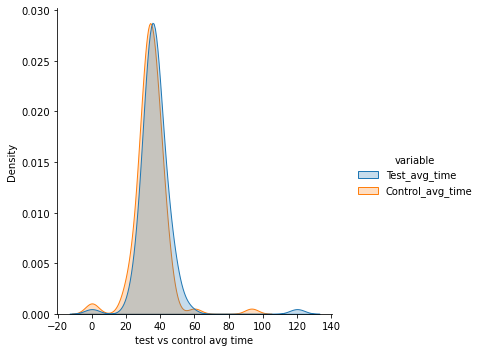

t_stat_b: 1.9175 p_value_b: 0.05664 t_stat_a: 3.40476 p_value_a: 0.00073  sam_size: 210  effect: 0.2739


In [61]:
conduct_stat_test(temp, 'test vs control avg time', 'test_vs_control_avg_time_dst.png', 'Test_avg_time', 'Control_avg_time')

In [62]:
temp = pd.merge(t[['date', 'Test_avg_PVs']],control_df[['date','Control_avg_PVs']], on = 'date', how = 'inner')
#temp.to_csv('test_vs_control_avg_PVs.csv', index = False)

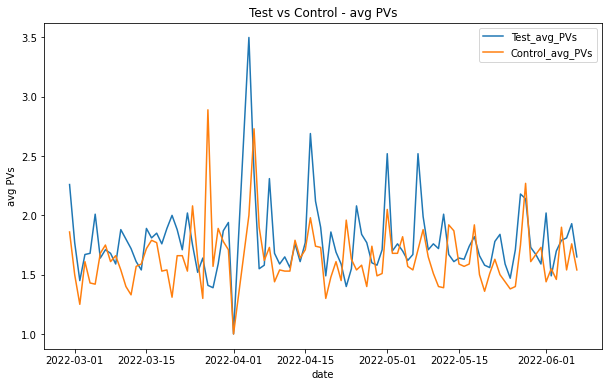

In [63]:
plt.figure(figsize = (10,6)) 
ax = sns.lineplot(x='date', y='value', hue='variable', data=pd.melt(temp[['date', 'Test_avg_PVs', 'Control_avg_PVs']], ['date']))
ax.set(xlabel='date', ylabel='avg PVs')
#plt.xticks(rotation=45)
plt.legend(title='')
plt.title("Test vs Control - avg PVs")
plt.savefig("test_vs_control_avg_PVs.png")
plt.show()

<Figure size 720x432 with 0 Axes>

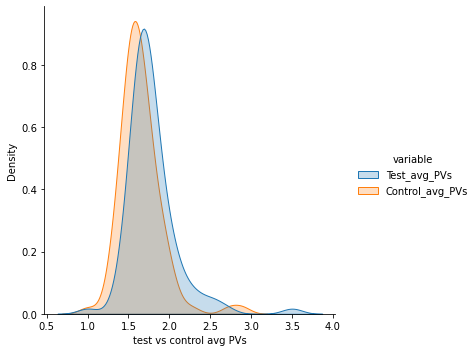

t_stat_b: 3.3185 p_value_b: 0.00108 t_stat_a: 4.21247 p_value_a: 4e-05  sam_size: 71  effect: 0.4741


In [64]:
conduct_stat_test(temp, 'test vs control avg PVs', 'test_vs_control_avg_PVs_dst.png', 'Test_avg_PVs', 'Control_avg_PVs')

### Geo vs Control

In [65]:
def rename_col(df, group):
    col = df.columns
    col = col.to_list()
    col = col[3:8]
    temp ={}
    for each in col:
        temp[each] = f'{group}_{each}'
        df.rename(columns = temp, inplace = True)
    return df

In [66]:
geo_df = test_df[(test_df['Geo'] == 'Geo') & (test_df['city_found'] == 'Yes')]
non_geo_df = test_df[(test_df['Geo'] == 'NonGeo') & (test_df['city_found'] == 'Yes')]

In [67]:
geo_df = rename_col(geo_df, 'Geo')
non_geo_df = rename_col(non_geo_df, 'NonGeo')

C:\Users\shubham.gupta\Anaconda3\lib\site-packages\pandas\core\frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [68]:
temp = pd.merge(geo_df[['date', 'Geo_Test_avg_time']],control_df[['date','Control_avg_time']], on = 'date', how = 'inner')
#temp.to_csv('geo_vs_control_avg_time.csv', index = False)

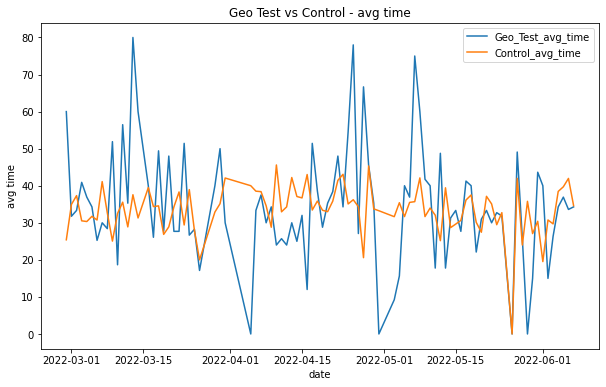

In [69]:
plt.figure(figsize = (10,6)) 
ax = sns.lineplot(x='date', y='value', hue='variable', data=pd.melt(temp[['date','Geo_Test_avg_time', 'Control_avg_time']], ['date']))
ax.set(xlabel='date', ylabel='avg time')
plt.legend(title='')
plt.title("Geo Test vs Control - avg time")
plt.savefig("geo_vs_control_avg_time.png")
plt.show()

<Figure size 720x432 with 0 Axes>

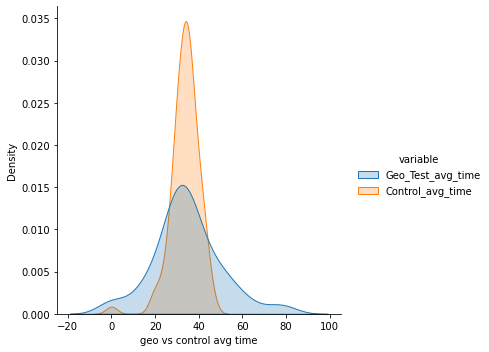

t_stat_b: 0.59492 p_value_b: 0.55265 t_stat_a: 3.89886 p_value_a: 0.0001  sam_size: 1997  effect: 0.0887


In [70]:
conduct_stat_test(temp, 'geo vs control avg time', 'geo_vs_control_avg_time_dst.png', 'Geo_Test_avg_time', 'Control_avg_time')

In [71]:
temp = pd.merge(geo_df[['date', 'Geo_Test_avg_PVs']],control_df[['date','Control_avg_PVs']], on = 'date', how = 'inner')
#temp.to_csv('geo_vs_control_avg_PVs.csv', index = False)

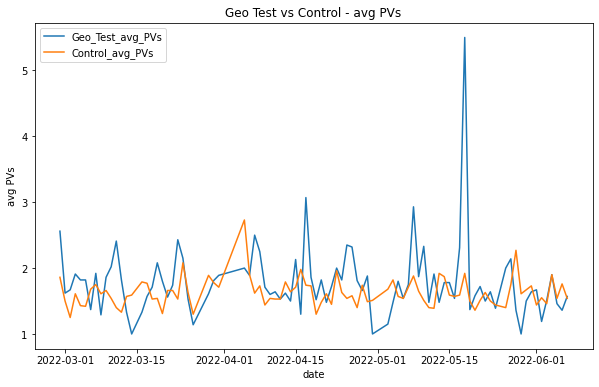

In [72]:
plt.figure(figsize = (10,6)) 
ax = sns.lineplot(x='date', y='value', hue='variable', data=pd.melt(temp[['date', 'Geo_Test_avg_PVs', 'Control_avg_PVs']], ['date']))
ax.set(xlabel='date', ylabel='avg PVs')
#plt.xticks(rotation=45)
plt.legend(title='')
plt.title("Geo Test vs Control - avg PVs")
plt.savefig("geo_vs_control_avg_PVs.png")
plt.show()

<Figure size 720x432 with 0 Axes>

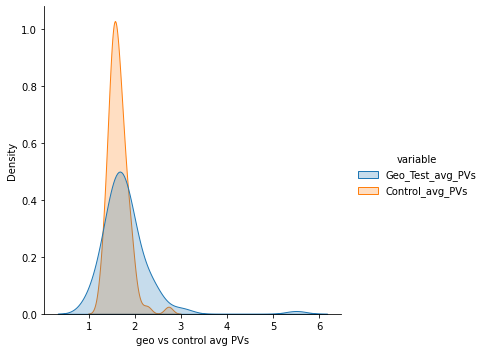

t_stat_b: 2.4875 p_value_b: 0.01378 t_stat_a: 2.68303 p_value_a: 0.00783  sam_size: 115  effect: 0.3708


In [73]:
conduct_stat_test(temp, 'geo vs control avg PVs', 'geo_vs_control_avg_PVs_dst.png', 'Geo_Test_avg_PVs', 'Control_avg_PVs')

### Non Geo vs Control

In [74]:
temp = pd.merge(non_geo_df[['date', 'NonGeo_Test_avg_time']],control_df[['date','Control_avg_time']], on = 'date', how = 'inner')
#temp.to_csv('nongeo_vs_control_avg_time.csv', index = False)

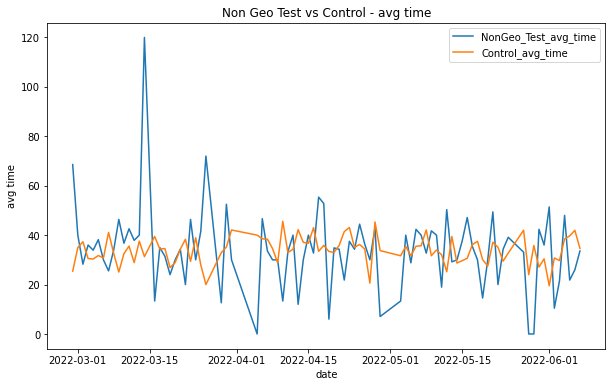

In [75]:
plt.figure(figsize = (10,6)) 
ax = sns.lineplot(x='date', y='value', hue='variable', data=pd.melt(temp[['date','NonGeo_Test_avg_time', 'Control_avg_time']], ['date']))
ax.set(xlabel='date', ylabel='avg time')
#plt.xticks(rotation=45)
plt.legend(title='')
plt.title("Non Geo Test vs Control - avg time")
plt.savefig("nongeo_vs_control_avg_time.png")
plt.show()

<Figure size 720x432 with 0 Axes>

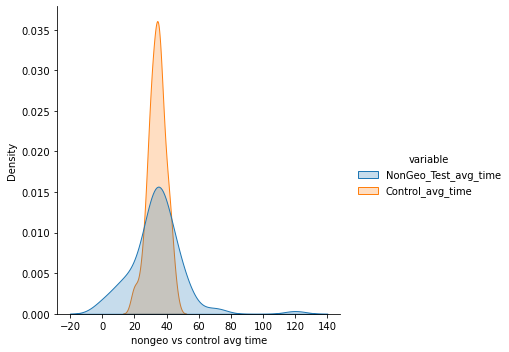

t_stat_b: -0.03896 p_value_b: 0.96897 t_stat_a: -1.07224 p_value_a: 0.28361  sam_size: 455080  effect: -0.0059


In [76]:
conduct_stat_test(temp, 'nongeo vs control avg time', 'nongeo_vs_control_avg_time_dst.png', 'NonGeo_Test_avg_time', 'Control_avg_time')

In [77]:
temp = pd.merge(non_geo_df[['date', 'NonGeo_Test_avg_PVs']],control_df[['date','Control_avg_PVs']], on = 'date', how = 'inner')
#temp.to_csv('nongeo_vs_control_avg_PVs.csv', index = False)

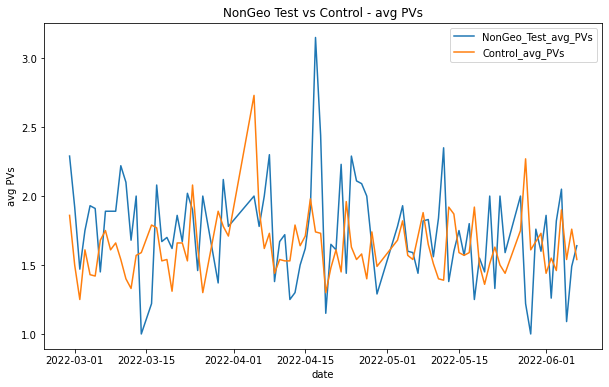

In [78]:
plt.figure(figsize = (10,6)) 
ax = sns.lineplot(x='date', y='value', hue='variable', data=pd.melt(temp[['date', 'NonGeo_Test_avg_PVs', 'Control_avg_PVs']], ['date']))
ax.set(xlabel='date', ylabel='avg PVs')
#plt.xticks(rotation=45)
plt.legend(title='')
plt.title("NonGeo Test vs Control - avg PVs")
plt.savefig("nongeo_vs_control_avg_PVs.png")
plt.show()

<Figure size 720x432 with 0 Axes>

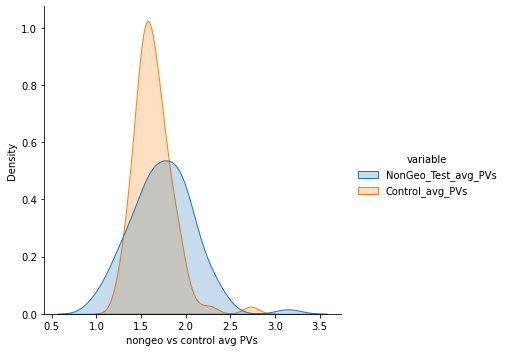

t_stat_b: 2.36228 p_value_b: 0.01927 t_stat_a: 5.001 p_value_a: 0.0  sam_size: 125  effect: 0.3561


In [79]:
conduct_stat_test(temp, 'nongeo vs control avg PVs', 'nongeo_vs_control_avg_PVs_dst.png', 'NonGeo_Test_avg_PVs', 'Control_avg_PVs')

### Geo vs Non Geo

In [80]:
temp = pd.merge(geo_df[['date', 'Geo_Test_avg_time']],non_geo_df[['date','NonGeo_Test_avg_time']], on = 'date', how = 'inner')
#temp.to_csv('geo_vs_nongeo_avg_time.csv', index = False)

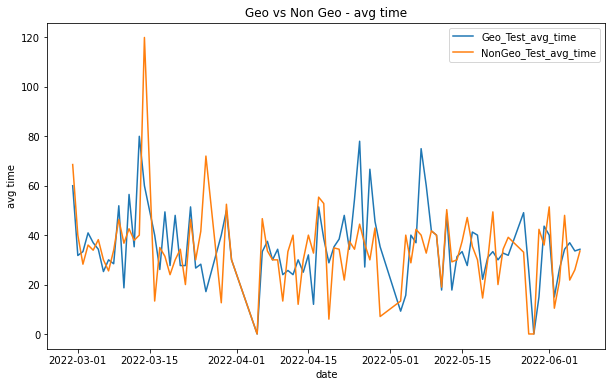

In [81]:
plt.figure(figsize = (10,6)) 
ax = sns.lineplot(x='date', y='value', hue='variable', data=pd.melt(temp[['date','Geo_Test_avg_time', 'NonGeo_Test_avg_time']], ['date']))
ax.set(xlabel='date', ylabel='avg time')
#plt.xticks(rotation=45)
plt.legend(title='')
plt.title("Geo vs Non Geo - avg time")
plt.savefig("geo_vs_non_geo_avg_time.png")
plt.show()

In [82]:
temp.head(2)

,date,Geo_Test_avg_time,NonGeo_Test_avg_time
0,2022-02-28,60.00,68.57
1,2022-03-01,31.76,40.00


<Figure size 720x432 with 0 Axes>

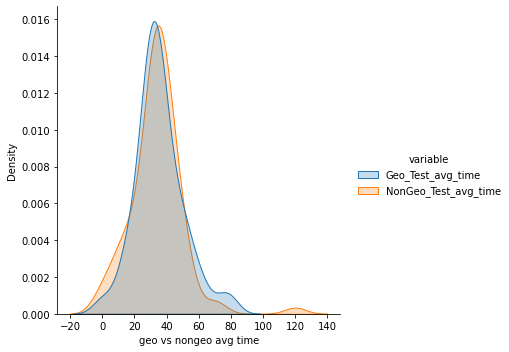

t_stat_b: 0.64973 p_value_b: 0.51672 t_stat_a: 1.9824 p_value_a: 0.04752  sam_size: 1637  effect: 0.098


In [83]:
conduct_stat_test(temp, 'geo vs nongeo avg time', 'geo_vs_nongeo_avg_time_dst.png', 'Geo_Test_avg_time', 'NonGeo_Test_avg_time')

In [84]:
temp = pd.merge(geo_df[['date', 'Geo_Test_avg_PVs']],non_geo_df[['date','NonGeo_Test_avg_PVs']], on = 'date', how = 'inner')
#temp.to_csv('geo_vs_nongeo_avg_PVs.csv', index = False)

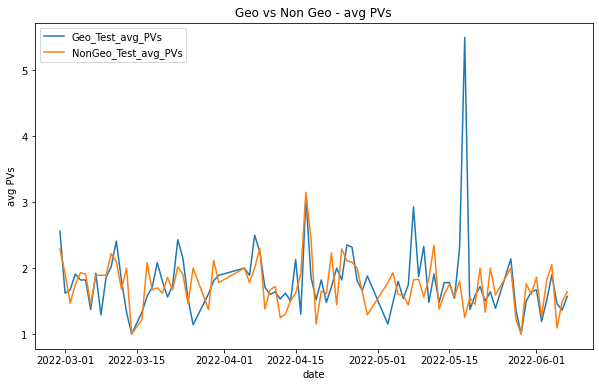

In [85]:
plt.figure(figsize = (10,6)) 
ax = sns.lineplot(x='date', y='value', hue='variable', data=pd.melt(temp[['date', 'Geo_Test_avg_PVs', 'NonGeo_Test_avg_PVs']], ['date']))
ax.set(xlabel='date', ylabel='avg PVs')
#plt.xticks(rotation=45)
plt.legend(title='')
plt.title("Geo vs Non Geo - avg PVs")
plt.savefig("geo_vs_non_geo_avg_PVs.png")
plt.show()

<Figure size 720x432 with 0 Axes>

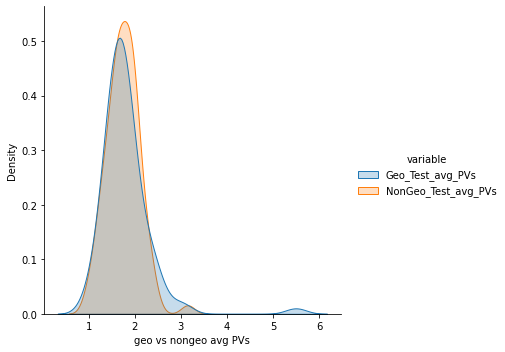

t_stat_b: 0.76381 p_value_b: 0.44602 t_stat_a: 3.26801 p_value_a: 0.0011  sam_size: 1185  effect: 0.1151


In [86]:
conduct_stat_test(temp, 'geo vs nongeo avg PVs', 'geo_vs_nongeo_avg_PVs_dst.png', 'Geo_Test_avg_PVs', 'NonGeo_Test_avg_PVs')

### Power analysis

In [ ]:
# Power = 1 - Type II Error
# Pr(True Positive) = 1 - Pr(False Negative)

In [ ]:
# effect size =  estimated diff. in the means/ pooled estimated st dv
# pooled estimated st dv = sqrt((sd1**2 + sd2**2)/2)

In [145]:
t = temp.describe()

In [146]:
mean_diff = (t.iloc[[1],0][0] - t.iloc[[1],1][0])
pooled_st_dv = math.sqrt(((t.iloc[[2],0][0])**2 + (t.iloc[[2],1][0])**2)/2)

In [147]:
effect_size = mean_diff/pooled_st_dv
effect_size

8.431914917446425

In [90]:
# estimate sample size via power analysis
# parameters for power analysis
effect = effect_size
alpha = 0.05
power = 0.8

# perform power analysis
analysis = TTestIndPower()
result = analysis.solve_power(effect, power=power, nobs1=None, ratio=1.0, alpha=alpha)
print('Sample Size: %.3f' % result)

Sample Size: 1184.880


In [91]:
temp

,date,Geo_Test_avg_PVs,NonGeo_Test_avg_PVs
0,2022-02-28,2.56,2.29
1,2022-03-01,1.62,1.92
2,2022-03-02,1.67,1.47
3,2022-03-03,1.91,1.75
4,2022-03-04,1.82,1.93
...,...,...,...
83,2022-06-03,1.51,1.82
84,2022-06-04,1.90,2.05
85,2022-06-05,1.46,1.09
86,2022-06-06,1.36,1.49


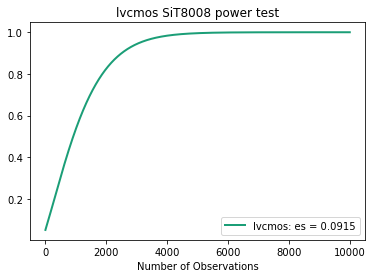

In [156]:
# effect size foe binomial for products
#effect_sizes = np.array([0.03873405847722755, 0.11315018751864536])
effect_sizes = np.array([0.091515])
sample_sizes = np.array(range(5, 10000))
  

obj = TTestIndPower()
obj.plot_power(dep_var='nobs', nobs=sample_sizes,
               effect_size=effect_sizes, alpha = 0.05)
#plt.title("product power test")
plt.title("lvcmos SiT8008 power test")
#plt.legend(['khz: es = 0.04', 'lvcmos: es = 0.11'])
plt.legend(['lvcmos: es = 0.0915'])
#plt.savefig("effect_size_product.png")
plt.savefig("effect_size_lvcmos_SiT8008.png")
plt.show()

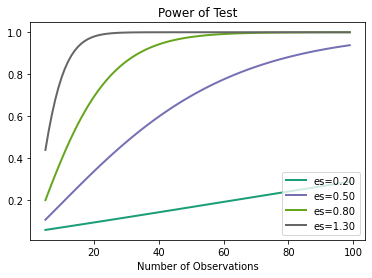

In [1222]:
effect_sizes = np.array([0.2, 0.5, 0.8, 1.3])
sample_sizes = np.array(range(5, 100))
  

obj = TTestIndPower()
obj.plot_power(dep_var='nobs', nobs=sample_sizes,
               effect_size=effect_sizes)
plt.show()

In [179]:
# calculate power curves from multiple power analyses
analysis = TTestIndPower()
analysis.plot_power(dep_var='nobs', nobs=arange(5, 100), effect_size=array([0.2, 0.5, 0.8]))

NameError: name 'arange' is not defined

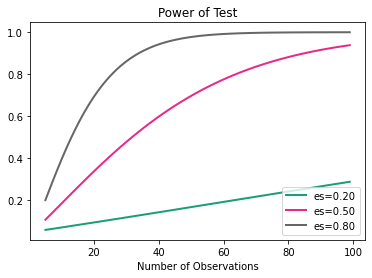

In [180]:
# calculate power curves for varying sample and effect size
from numpy import array
from matplotlib import pyplot
from statsmodels.stats.power import TTestIndPower
# parameters for power analysis
effect_sizes = array([0.2, 0.5, 0.8])
sample_sizes = array(range(5, 100))
# calculate power curves from multiple power analyses
analysis = TTestIndPower()
analysis.plot_power(dep_var='nobs', nobs=sample_sizes, effect_size=effect_sizes)
pyplot.show()